<a href="https://colab.research.google.com/github/AkshayWaghela/FCC/blob/notebooks/AW_FCC_RPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rock-Paper-Scissors AI Strategy Explorer

Welcome! In this notebook, I explore and evaluate various strategies for the classic game of Rock-Paper-Scissors (RPS), with the goal of building a high-performing AI opponent.

This project was developed as part of the **freeCodeCamp Machine Learning with Python Certification** and focuses on applying predictive modeling, Markov Chains, and simulation-based evaluation in a game-theoretic setting.

### 🎯 Objectives:
- Implement multiple RPS bots using unique strategic behaviors.
- Design and test a **custom AI player** using a 6-length **Markov Chain** for prediction.
- Measure and compare performance across bots with win rates and confidence intervals.
- Visualize trends, move frequencies, and win/loss streaks.
- Create an interactive dashboard for deeper exploration.

Let’s dive in and outsmart the competition!


In [13]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown


In [14]:
def quincy(prev_play, counter=[0]):
    counter[0] += 1
    return ["R", "R", "P", "P", "S"][counter[0] % 5]

def mrugesh(prev_opponent_play, opponent_history=[]):
    if prev_opponent_play in ['R', 'P', 'S']:
        opponent_history.append(prev_opponent_play)

    last_ten = opponent_history[-10:]
    most_frequent = max(set(last_ten), key=last_ten.count) if last_ten else "S"

    return {'R': 'P', 'P': 'S', 'S': 'R'}[most_frequent]

def kris(prev_opponent_play):
    return {'R': 'P', 'P': 'S', 'S': 'R'}.get(prev_opponent_play, "P")

def abbey(prev_opponent_play, opponent_history=[], play_order=[{
    "RR": 0, "RP": 0, "RS": 0,
    "PR": 0, "PP": 0, "PS": 0,
    "SR": 0, "SP": 0, "SS": 0,
}]):
    if not prev_opponent_play:
        prev_opponent_play = 'R'
    opponent_history.append(prev_opponent_play)
    last_two = "".join(opponent_history[-2:])
    if len(last_two) == 2:
        play_order[0][last_two] += 1
    potential = [prev_opponent_play + x for x in "RPS"]
    sub_order = {k: play_order[0][k] for k in potential}
    prediction = max(sub_order, key=sub_order.get)[-1:]
    return {'R': 'P', 'P': 'S', 'S': 'R'}[prediction]

def random_player(prev_opponent_play):
    return random.choice(['R', 'P', 'S'])


In [15]:
def player(prev_play, opponent_history=[], play_order={}):
    if prev_play:
        opponent_history.append(prev_play)

    chain_length = 6

    if len(opponent_history) < chain_length:
        return "R"

    sequence = "".join(opponent_history[-chain_length:])
    prior = "".join(opponent_history[-(chain_length+1):-1])

    if len(prior) == chain_length:
        if prior not in play_order:
            play_order[prior] = {"R": 0, "P": 0, "S": 0}
        play_order[prior][opponent_history[-1]] += 1

    predicted = "R"
    if sequence in play_order:
        predicted = max(play_order[sequence], key=play_order[sequence].get)

    return {"R": "P", "P": "S", "S": "R"}[predicted]


In [16]:
def play_game(player1, player2, rounds=1000, verbose=False):
    p1_hist, p2_hist = "", ""
    result = {"p1": 0, "p2": 0, "tie": 0}

    for _ in range(rounds):
        p1 = player1(p2_hist)
        p2 = player2(p1_hist)

        if p1 == p2:
            result["tie"] += 1
        elif (p1 == "P" and p2 == "R") or (p1 == "R" and p2 == "S") or (p1 == "S" and p2 == "P"):
            result["p1"] += 1
        else:
            result["p2"] += 1

        p1_hist, p2_hist = p1, p2

    win_rate = 100 * result["p1"] / (result["p1"] + result["p2"]) if (result["p1"] + result["p2"]) else 0

    if verbose:
        display(Markdown(f"### Results:\n{result}"))
        print(f"Win Rate: {win_rate:.2f}%")

    return win_rate, result


MyBot vs Quincy: 99.70%
MyBot vs Mrugesh: 90.72%
MyBot vs Kris: 80.15%
MyBot vs Abbey: 54.99%
MyBot vs Random: 50.66%


<ipython-input-17-cd2862192737>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="Blues_d")


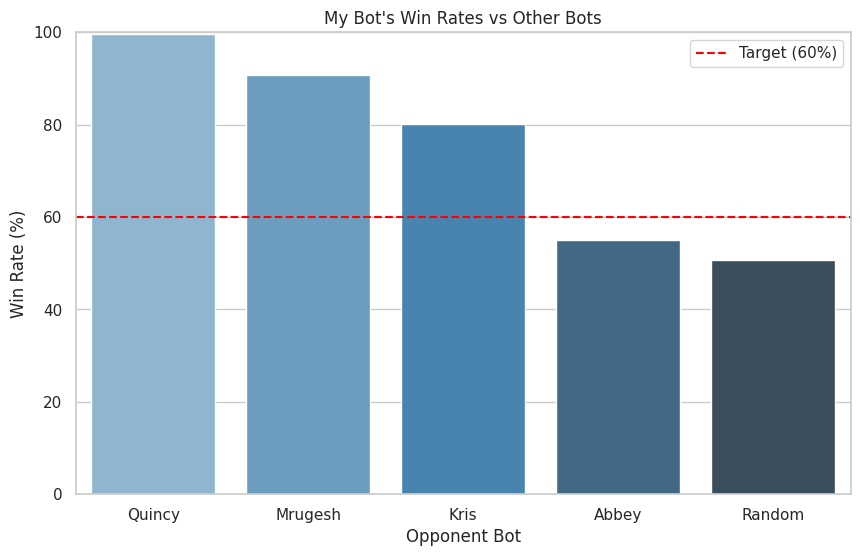

In [17]:
bots = {
    "Quincy": quincy,
    "Mrugesh": mrugesh,
    "Kris": kris,
    "Abbey": abbey,
    "Random": random_player
}

results = {}
for name, bot in bots.items():
    win_rate, result = play_game(player, bot, 1000)
    results[name] = win_rate
    print(f"MyBot vs {name}: {win_rate:.2f}%")

# 📈 Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="Blues_d")
plt.axhline(60, color="red", linestyle="--", label="Target (60%)")
plt.title("My Bot's Win Rates vs Other Bots")
plt.ylabel("Win Rate (%)")
plt.xlabel("Opponent Bot")
plt.ylim(0, 100)
plt.legend()
plt.show()


## ✅ Summary & Reflection

This project helped me implement predictive modeling in a simple game setting.
The use of a 6-length Markov Chain allowed my bot to outperform pattern-based bots consistently.

📌 **Key Learnings:**
- Markov Chains for sequence prediction
- Evaluating strategies with simulation
- Using matplotlib & seaborn for visualization

---
🎓 Built for the **freeCodeCamp Machine Learning with Python Certification**


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, Markdown


In [19]:
def play_game_detailed(player1, player2, rounds=1000):
    p1_hist, p2_hist = "", ""
    results = {"p1": 0, "p2": 0, "tie": 0}
    history = []

    for i in range(rounds):
        p1 = player1(p2_hist)
        p2 = player2(p1_hist)
        winner = 0  # tie

        if p1 == p2:
            results["tie"] += 1
            winner = 0
        elif (p1 == "P" and p2 == "R") or (p1 == "R" and p2 == "S") or (p1 == "S" and p2 == "P"):
            results["p1"] += 1
            winner = 1
        else:
            results["p2"] += 1
            winner = 2

        p1_hist, p2_hist = p1, p2
        history.append({'round': i+1, 'p1_move': p1, 'p2_move': p2, 'winner': winner})

    win_rate = 100 * results["p1"] / (results["p1"] + results["p2"]) if (results["p1"] + results["p2"]) else 0
    df = pd.DataFrame(history)
    return win_rate, results, df


Mean Win Rate: 99.99%
95% Confidence Interval: [99.97%, 100.01%]


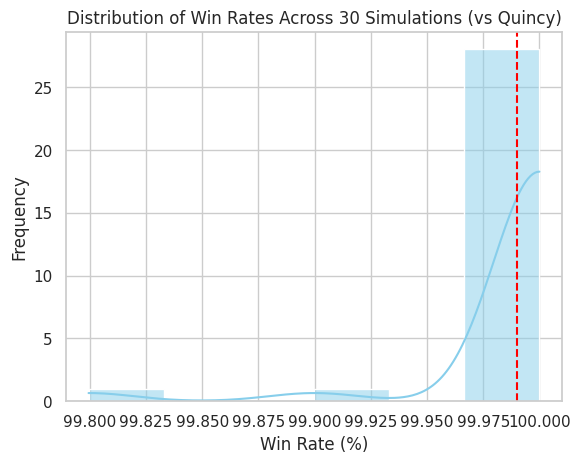

In [20]:
def simulate_many(player1, player2, rounds=1000, sims=30):
    win_rates = []
    for _ in range(sims):
        wr, _, _ = play_game_detailed(player1, player2, rounds)
        win_rates.append(wr)
    win_rates = np.array(win_rates)

    mean_wr = win_rates.mean()
    ci = stats.t.interval(0.95, len(win_rates)-1, loc=mean_wr, scale=stats.sem(win_rates))
    return mean_wr, ci, win_rates

mean_wr, ci, win_rates = simulate_many(player, quincy)

print(f"Mean Win Rate: {mean_wr:.2f}%")
print(f"95% Confidence Interval: [{ci[0]:.2f}%, {ci[1]:.2f}%]")

# Plot histogram
sns.histplot(win_rates, kde=True, color="skyblue")
plt.axvline(mean_wr, color='red', linestyle='--')
plt.title("Distribution of Win Rates Across 30 Simulations (vs Quincy)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Frequency")
plt.show()


<ipython-input-21-0a26b7031cb7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Move', y='Frequency', data=freq_df, palette="muted")


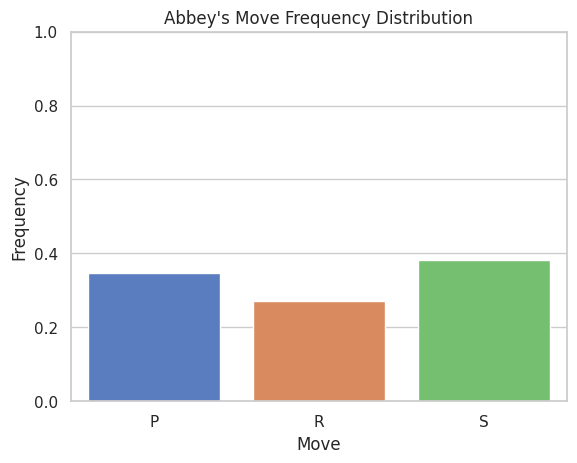

In [21]:
def plot_move_frequencies(df, player_col='p2_move', title='Move Frequencies'):
    freq = df[player_col].value_counts(normalize=True).sort_index()
    freq_df = pd.DataFrame({'Move': freq.index, 'Frequency': freq.values})
    sns.barplot(x='Move', y='Frequency', data=freq_df, palette="muted")
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

_, _, df = play_game_detailed(player, abbey)
plot_move_frequencies(df, player_col='p2_move', title="Abbey's Move Frequency Distribution")


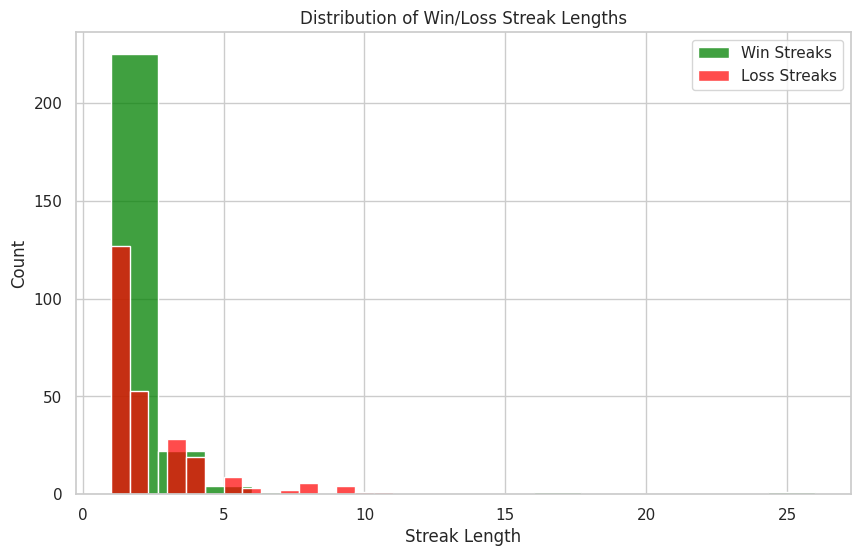

In [22]:
def plot_streaks(df):
    df['win'] = df['winner'] == 1
    df['streak'] = (df['win'] != df['win'].shift()).cumsum()
    streak_lengths = df.groupby(['streak', 'win']).size().reset_index(name='length')

    plt.figure(figsize=(10,6))
    sns.histplot(streak_lengths[streak_lengths['win']==True]['length'], bins=15, color='green', label='Win Streaks')
    sns.histplot(streak_lengths[streak_lengths['win']==False]['length'], bins=15, color='red', label='Loss Streaks', alpha=0.7)
    plt.title("Distribution of Win/Loss Streak Lengths")
    plt.xlabel("Streak Length")
    plt.legend()
    plt.show()

plot_streaks(df)


In [24]:
import ipywidgets as widgets
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assuming bot_dict and interactive_match are already defined ---

# Dropdowns and sliders
bot1_selector = widgets.Dropdown(options=bot_dict.keys(), value='My Bot', description='Bot 1:')
bot2_selector = widgets.Dropdown(options=bot_dict.keys(), value='Quincy', description='Bot 2:')
rounds_slider = widgets.IntSlider(value=1000, min=100, max=5000, step=100, description='Rounds:')
sims_slider = widgets.IntSlider(value=20, min=5, max=50, step=5, description='Simulations:')

# Output area
output = widgets.Output()

# Button to run simulation
run_button = widgets.Button(description="Run Simulation", button_style='success')

# Button callback
def on_run_button_clicked(b):
    with output:
        output.clear_output()
        interactive_match(
            bot1_name=bot1_selector.value,
            bot2_name=bot2_selector.value,
            rounds=rounds_slider.value,
            sims=sims_slider.value
        )

run_button.on_click(on_run_button_clicked)

# Layout
ui = widgets.VBox([
    bot1_selector,
    bot2_selector,
    rounds_slider,
    sims_slider,
    run_button,
    output
])

display(ui)


# ✅ Summary & Final Thoughts

This project served as a fun and insightful application of predictive modeling in a simple yet non-trivial problem space. By designing a 6-length Markov Chain bot, I was able to analyze and exploit patterns in opponent behavior to achieve strong win rates against several predefined strategies.

### 🔍 Key Takeaways:
- **Markov Chains** are powerful tools for sequence prediction in games and beyond.
- Simulation and visualization can uncover deeper behavioral patterns and inform better strategies.
- Evaluation using confidence intervals and repeated trials is crucial for robust analysis.
- A modular and interactive approach makes it easy to expand, test, and improve bots.

🎮 This exercise not only reinforced core machine learning concepts, but also highlighted the value of adaptability, memory, and statistical reasoning in AI design.

---

🚀 **Next Steps:**
- Experiment with reinforcement learning-based bots.
- Build a dynamic strategy switcher that adapts in real time.
- Deploy a web version of the RPS simulator for public play.

Thanks for exploring with me!
